# STILL NONSENSE TESTING - IGNORE 

In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

from braincoder.utils.visualize import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-02-18 10:22:11.548125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 10:22:11.548183: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 10:22:11.548197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 10:22:11.558002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Simulate data

In [2]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
# sfs_seq = np.append(sfs_seq, np.zeros(500))

con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
# con_seq = np.append(con_seq, np.zeros(500))
paradigm = np.vstack([sfs_seq, con_seq])


In [3]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [4]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0.68, 0.68],     # we fix width_l in our model
    'crf_exp'   : [0, 5] ,
    'amplitude' : [0, 10],       # Amplitude of TC
    'baseline'  : [-2,2]
}
n_vx = 100
parameters = pd.DataFrame({
    key:np.random.uniform(bounds[key][0], bounds[key][1], n_vx) for key in bounds
}).astype('float32')

n_vx = parameters.shape[0]
idx_cols = sns.color_palette("hsv", n_vx)

In [5]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

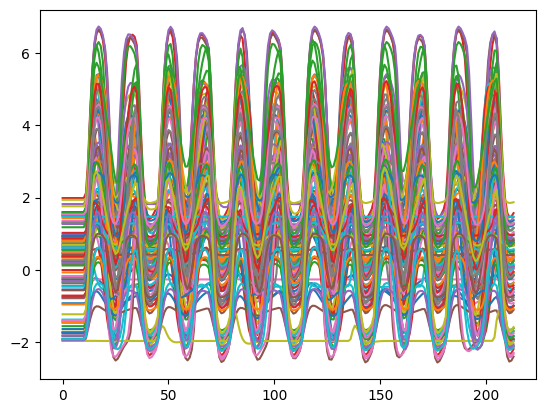

In [6]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred)

In [7]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

try:
    if tf.config.list_physical_devices('GPU'):
        with tf.device('/GPU:0'):
            # Create a simple convolutional layer
            conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')

            # Create a dummy input tensor (batch_size, height, width, channels)
            input_tensor = tf.random.uniform(shape=(1, 28, 28, 3))

            # Pass the input through the convolutional layer
            output_tensor = conv_layer(input_tensor)

            print("GPU convolution successful!")
            print("Output shape:", output_tensor.shape)

    else:
        print("GPU device not found. Running on CPU.")

except Exception as e:
    print(f"Error during GPU convolution:")
    print(e)

Num GPUs Available: 1
Error during GPU convolution:
Could not satisfy device specification '/job:localhost/replica:0/task:0/device:GPU:0'. enable_soft_placement=0. Supported device types [CPU]. All available devices [/job:localhost/replica:0/task:0/device:CPU:0].


In [8]:
tf.__version__

'2.14.0'

# Classic fitter

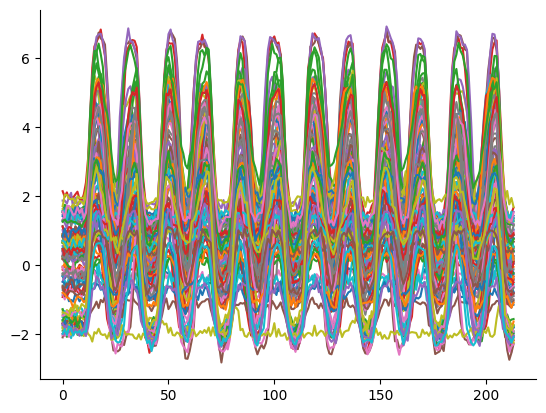

In [9]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [10]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
cfitter = ParameterFitter(model, data, model.paradigm)
grid_pars = cfitter.fit_grid(
    width_r     =np.linspace(bounds['width_r'][0], bounds['width_r'][1], 5),
    SFp         =np.linspace(bounds['SFp'][0], bounds['SFp'][1], 5),
    CSp         =np.linspace(bounds['CSp'][0], bounds['CSp'][1], 10),
    width_l     =np.linspace(bounds['width_l'][0], bounds['width_l'][1], 5),
    crf_exp     =np.linspace(bounds['crf_exp'][0], bounds['crf_exp'][1], 5),
    amplitude   =[1.0],
    baseline    =[0],
    use_correlation_cost=True
)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars, fixed_pars={'width_l' : 0.68})

/home/daghlian/.conda/envs/bcoder2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with chunk size of 31152
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/braincoder_bprf/braincoder/optimize.py:426: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.07244527e+00 4.04800701e+00 4.89974880e+00 7.30552959e+00
 5.96300364e+00 8.96549129e+00 1.00000000e-04 9.10693550e+00
 5.60667324e+00 5.32956457e+00 3.03478003e+00 6.36617851e+00
 7.36198854e+00 1.63130522e+00 7.63409233e+00 2.00407577e+00
 3.06851983e+00 8.13444734e-01 4.72924900e+00 8.48774493e-01
 4.96030903e+00 5.12565136e+00 2.57844973e+00 3.78005624e+00
 8.21136379e+00 5.82758713e+00 5.99520493e+00 3.92758036e+00
 4.88928795e+00 2.27464795e+00 9.46833670e-01 2.61898065e+00
 3.49766374e+00 7.77699614e+00 4.56633806e+00 1.18496299e+00
 5.49667454e+00 4.85560656e+00 4.57936573e+00 6.78268766e+00
 5.36268806e+00 4.23042154e+00 7.28792572e+00 4.50438595e+00
 5.56859350e+00 5.07196093e+00 6.12528801e+00 3.710432

*** Only fitting: ***
 * width_r
 * SFp
 * CSp
 * crf_exp
 * amplitude
 * baseline
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


  0%|          | 0/1000 [00:00<?, ?it/s]2025-02-18 10:22:26.803265: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55eef598d9a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-02-18 10:22:26.803308: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-02-18 10:22:26.906534: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-18 10:22:27.210143: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-18 10:22:27.215770: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
Current R2: nan/Best R2: 0.91476: 100%|██████████| 1000/1000 [00:24<00:00, 40.39it/s] 


/home/daghlian/.conda/envs/bcoder2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/tmp/ipykernel_1551594/3362790475.py:21: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(bounds[param])
/tmp/ipykernel_1551594/3362790475.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(bounds[param])


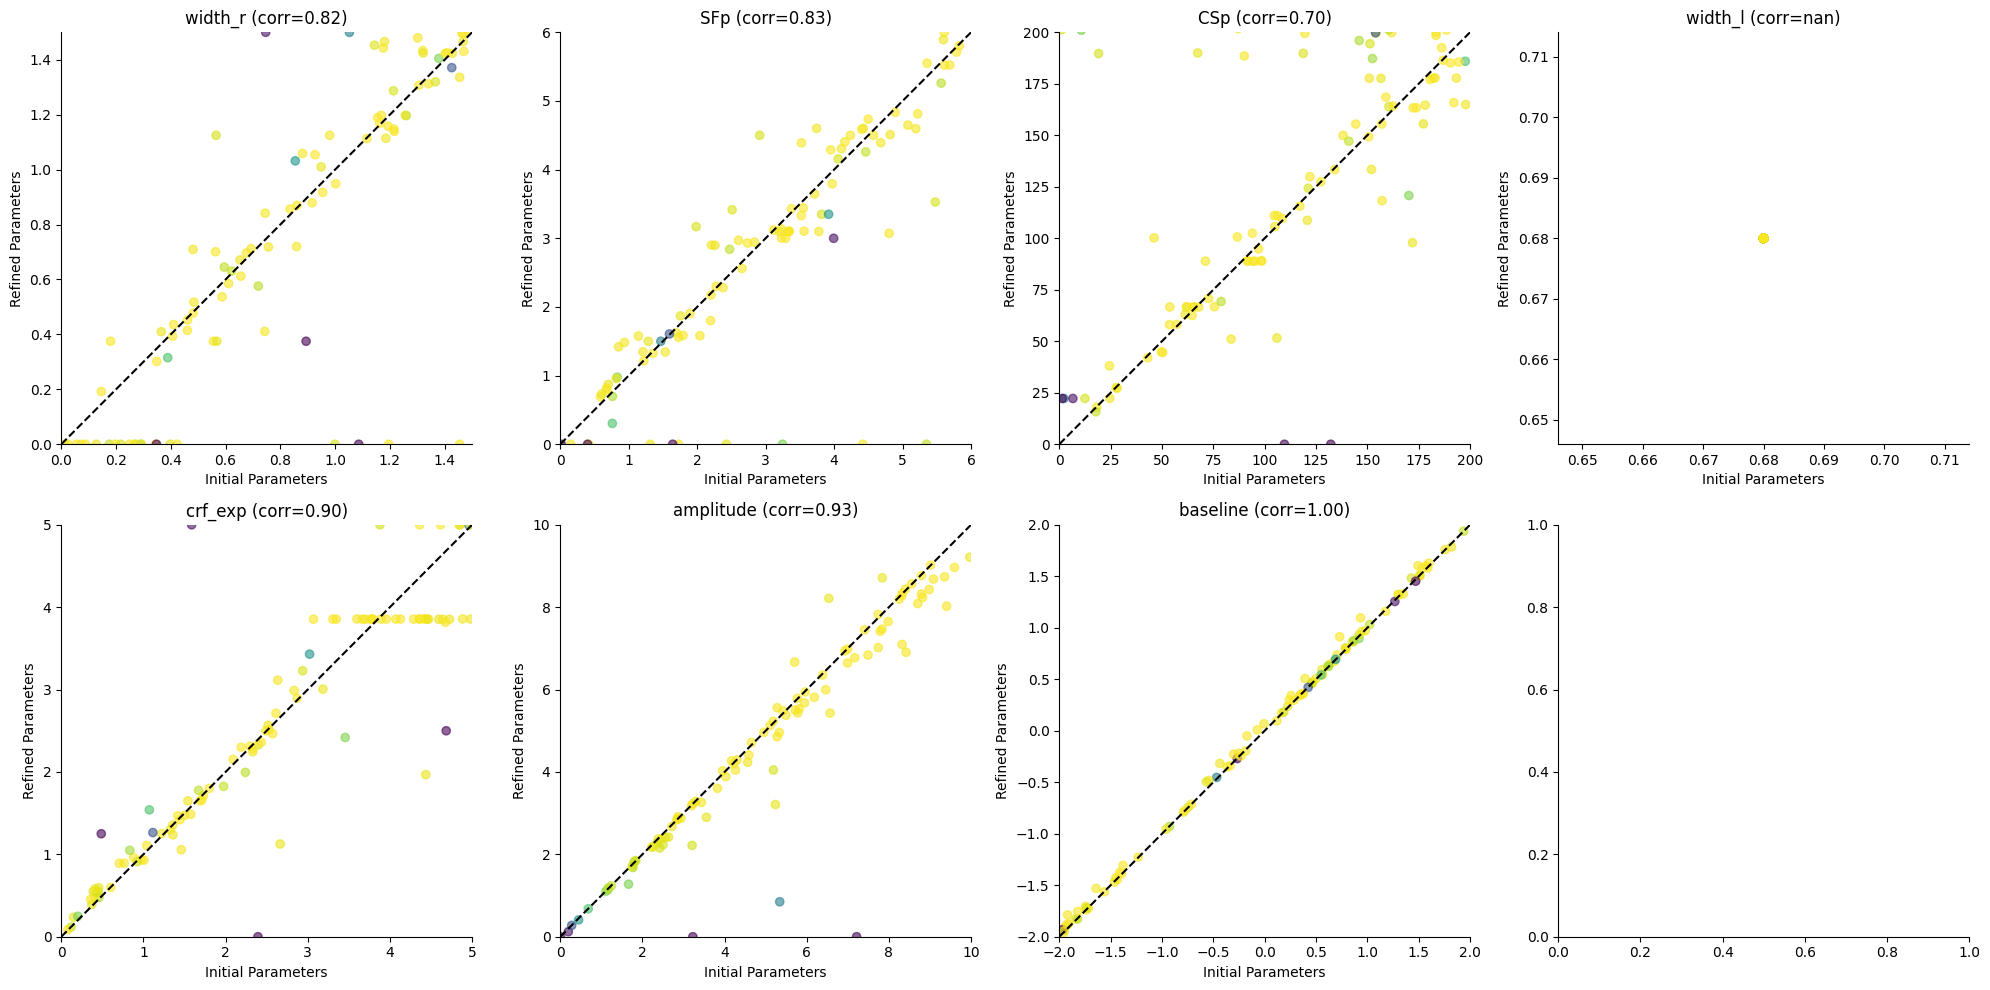

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
param_names = parameters.columns
rsq = cfitter.get_rsq(parameters=refined_pars)
for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(
        parameters[param], 
        refined_pars[param], 
        c=rsq, 
        alpha=0.6,
        cmap='viridis',
        vmin=0, vmax=1,
        )
    corr = np.corrcoef(parameters[param], refined_pars[param])[0, 1]
    ax.set_title(f'{param} (corr={corr:.2f})')
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
    # ax.set_aspect('square')
    sns.despine()

plt.tight_layout()
plt.show()

In [12]:
bfitter = BPRF(model, data, noise_method='fit_tdist')
# bfitter.add_priors_from_bounds(
#     bounds, 
# )
bfitter.add_bijector_from_bounds(
    bounds
)


init_pars = {
    'width_r' : np.ones(n_vx) * 1,
    'SFp' : np.ones(n_vx) * 2,
    'CSp' : np.ones(n_vx) * 100,
    'width_l' : np.ones(n_vx) * 0.68,
    'crf_exp' : np.ones(n_vx) * 1,
    'amplitude' : np.ones(n_vx) * 1, 
    'baseline' : np.ones(n_vx) * 0, 
    'noise_dof' : np.ones(n_vx) * 1, 
    'noise_scale' : np.ones(n_vx) * .5, 
}
init_pars = pd.DataFrame(init_pars)

bfitter.fit_mcmc(
    idx=[0,1,2,3,4],
    init_pars=init_pars,
    fixed_pars={'width_l':0.68},
    num_steps=10,
    burnin=50, 
    # max_tree_depth=5, 
    # target_accept_prob=0.85, 
)
print(bfitter.mcmc_stats['elapsed_time'])

Lets run some checks with everything...
tf.Tensor([-394.00647 -639.21826 -448.76236 -913.42957 -721.4664 ], shape=(5,), dtype=float32)
Using tape.gradient to check gradients w/respect to each parameter
Gradient for parameter 0: [ 24.753445  -16.096302  -21.48779    -5.9784756 -19.536854 ]
Gradient for parameter 1: [-5.7540417  3.7469528  4.9544373  1.2194557  5.198175 ]
Gradient for parameter 2: [-0.19938403  0.14062315  0.17353174  0.05760979  0.11186221]
Gradient for parameter 3: [0. 0. 0. 0. 0.]
Gradient for parameter 4: [-4.8908386  -0.02423096 -1.1784439  -1.3125267   1.4445267 ]
Gradient for parameter 5: [-79.24116   43.20477   51.312515  17.955713  39.155346]
Gradient for parameter 6: [-368.50803  241.7606   318.93796  141.5404   205.51117]
Gradient for parameter 7: [  50.46335   -37.54474    10.481368 -160.99603   -72.13803 ]
Gradient for parameter 8: [203.20685 341.59833 152.79071 396.2152  367.72162]
initial_ll=[-394.00647 -639.21826 -448.76236 -913.42957 -721.4664 ]
Starting

KeyboardInterrupt: 

In [38]:
# import pickle
# with open('./bfitter_big_sim.pkl', 'wb') as file:
#     pickle.dump(bfitter.mcmc_sampler, file)

In [ ]:
bfitter.mcmc_stats.keys()
# bfitter.mcmc_stats['leapfrogs_taken']



In [ ]:
idx = 0
p = 'width_r'
plt.plot(
    bfitter.mcmc_sampler[idx][p]
)
try:
    plt.axhline(parameters[p][idx], linestyle=':', color='k', lw=5)
    plt.axhline(refined_pars[p][idx] , linestyle=':', color='r')
except:
    print('nope')
plt.figure()
plt.plot(data.iloc[:,idx], ':k')
preds = bfitter.get_predictions(parameters=bfitter.mcmc_sampler[idx])
plt.plot(preds, alpha=1, color='g')
cpreds = model.predict(parameters=refined_pars)
plt.plot(cpreds.iloc[:,idx], ':r')

In [ ]:
bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx])

In [ ]:
rsq = bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx])
from dag_prf_utils.plot_functions import *
dag_scatter(
    X=rsq, Y=bfitter.mcmc_sampler[0]['noise_scale'].values, #pc=bfitter.mcmc_sampler[0]
    x_lim=[.8,1]
)


In [ ]:
rsq.argmax()

In [ ]:
bfitter.mcmc_sampler[0]

In [ ]:
data

In [ ]:
bfitter.mcmc_sampler[idx]

In [ ]:
bfitter.mcmc_sampler[idx][p]

In [ ]:
idx = 1
rsq = bfitter.get_rsq_for_idx(
    idx=idx, 
    parameters=bfitter.mcmc_sampler[idx]

)
plt.plot(rsq)

In [ ]:
# Lets see are we getting closer?
fig,axs = plt.subplots(2,5,figsize=(20,10))
axs = axs.flatten()
idx = 0
for ip,p in enumerate(bfitter.model_labels):
    ax = axs[ip]
    ax.set_title(p)
    ax.set_xlabel('Step in MCMC chain')
    # for i in range(10):

    ax.plot(
        bfitter.mcmc_sampler[idx][p],# - parameters[p][idx],
        color=idx_cols[idx],        
        )
    try:
        # Lets add the ground truth
        ax.axhline(
            parameters[p][idx], 
            color=idx_cols[idx],        
            linestyle=':'
        )
    except:
        continue
ax = axs[-1]
ax.set_title('Rsq')

rsq = bfitter.get_rsq_for_idx(
    idx=idx, parameters=bfitter.mcmc_sampler[idx],
)
plt.plot(
    rsq, 
    color=idx_cols[i]
    ) 
plt.ylim(0,1)
plt.tight_layout()

In [ ]:
idx = 20
burn_in = 50
sns_plot = sns.pairplot(
    bfitter.mcmc_sampler[idx].iloc[burn_in:,:],
    # plot_kws={'color':rsq_cols[burn_in:,:]},
    corner=True, 
    diag_kind='kde'
)
# sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
step_sizes = [.00001,  0.001, 0.005, 0.01, 0.05]
unrolled_steps = [1, 2, 3]
tree_depths = [5, 10, 15]

for step_size in step_sizes:
    for unroll in unrolled_steps:
        for depth in tree_depths:
            print(f"\nTrying step_size={step_size}, unrolled_steps={unroll}, tree_depth={depth}")
            try:
                bfitter.fit_all(
                    init_pars=init_pars,
                    num_steps=10,
                    burnin=10, 
                    unrolled_leapfrog_steps=unroll,
                    step_size=step_size,
                    max_tree_depth=depth
                )
            except Exception as e:
                print(f"Failed with error: {e}")
            plt.figure()
            rsq = []
            for idx in range(bfitter.n_voxels):
                rsq.append(bfitter.get_rsq_for_idx(idx=idx, parameters=bfitter.mcmc_sampler[idx]).T)
            plt.plot(np.array(rsq).T)
            plt.title(
                f"\nTrying step_size={step_size}, unrolled_steps={unroll}, tree_depth={depth}"
            )
        bloop





In [ ]:
idx = 10


In [ ]:
bfitter.mcmc_sampler[idx]

In [ ]:
idx = 1
burn_in = 100
plt.plot(cfitter.data.iloc[:,idx], ':k')
cpred = model.predict(parameters=refined_pars)
plt.plot(cpred.iloc[:,idx], 'b')
plt.text(
    x=1, y=0.9,  # Using axes coordinates (0-1 range)
    s=f"TRUTH {idx}:\n{parameters.iloc[idx,:].apply(lambda x: f'{x:.3f}').to_string()}",
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontdict={'family': 'monospace', 'size': 8}
)
plt.text(
    x=1.3, y=0.9,  # Using axes coordinates (0-1 range)
    s=f"FIT {idx}:\n{refined_pars.iloc[idx,:].apply(lambda x: f'{x:.3f}').to_string()}",
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontdict={'family': 'monospace', 'size': 8}
)
# this_pred = bfitter.model.predict(
#     parameters=bfitter.mcmc_sampler[idx]
# )
# plt.plot(
#     this_pred.iloc[:,burn_in:], '-g', alpha=.1,
# )

In [ ]:
idx = 500
pred = bfitter.get_predictions(
    parameters=bfitter.mcmc_sampler[idx],
    # c=rsq_cols[500:,:]
)
# colors = [tuple(color) for color in rsq_cols[id_start:, :-1]]
plt.plot(
    pred.iloc[:,burn_in:],
    # c=colors,
)
plt.plot(data.iloc[:,idx])


In [ ]:
idx = 0
burn_in = 100
sns_plot = sns.pairplot(
    fitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
a = fitter.mcmc_sampler[1]
pred = model.predict(parameters=a.iloc[:1,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

In [ ]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

In [24]:
fitter.mcmc_sampler[0]

In [ ]:
import corner as corner
_ = corner.corner(
    bfitter.mcmc_sampler[1].iloc[500:,:],# truths=parameters.iloc[0,:].T
    # truths=parameters.iloc[1,:]
)
print(parameters.iloc[1,:])
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

In [ ]:
pred = fitter.model.predict(
    parameters=fitter.mcmc_sampler[1].iloc[7483:7484,:]
)
pred.plot()
data.iloc[:,0].plot()

In [ ]:
fitter.mcmc_stats[1]['log_prob'].numpy().argmax()

In [ ]:
parameters.keys()
a.keys()

In [ ]:
parameters

In [ ]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [ ]:
data.iloc[:,0]

In [ ]:
Code

In [ ]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

In [ ]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [ ]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))
